# Measuring Impact of a Property on Local Network Predictions

Deep learning models achieve high predictive performance but lack intrinsic interpretability, hindering our understanding of the learned prediction behavior. Existing local explainability methods focus on associations, neglecting the causal drivers of model predictions. Other approaches adopt a causal perspective but primarily provide global, model-level explanations. However, for specific inputs, it's unclear whether globally identified factors apply locally. To address this limitation, we introduce a novel framework for local interventional explanations by leveraging recent advances in image-to-image editing models. Our approach performs gradual interventions on semantic properties to quantify the corresponding impact on a model's predictions using a novel score, the expected property gradient magnitude. 

In this notebook, we provide some minimal tutorial code to explain local decisions of some classifiers.

In [1]:
from propgrad.convmixer import ConvMixer
from propgrad.zollstock import Zollstock
from propgrad.pix2pix_interventions import pix2pix_edit
from propgrad.utils import subsample_plot, ImageList_DS, perform_inference

from PIL import Image
from celluloid import Camera
import torch
import pandas as pd
import numpy as np
from torch.utils import data
from torchvision import transforms
from IPython.display import HTML

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update(
    {
        'text.usetex': True,
        "font.family": "serif",
        "font.size": 22,
        "pgf.texsystem": "pdflatex",
        "pgf.rcfonts": False,
    }
)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amssymb}\usepackage{wasysym}')

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/penzel/miniconda3/envs/propgrad/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Loading some classifiers that we wish to explain.

We use simple ConvMixer models that we also describe in our paper. We include the weights here, to have some simple models for testing.
In particular, we include three models that only differ in their training distribution.
1. checkpoints/cats-vs-dogs/convmixer_dark-cats-bias.pth, which was trained on dark furred cat and light furred dog images
2. checkpoints/cats-vs-dogs/convmixer_dark-dogs-bias.pth, which was trained on light furred cat and dark furred dog images
3. checkpoints/cats-vs-dogs/convmixer_unbiased.pth, which was trained on the original distribution with only minimal correlation for the fur color and a specific class.

In [2]:
def load_cm(path, verbose=False):
    load_dict = torch.load(path)

    M = ConvMixer(**load_dict["paras"])
    M.load_state_dict(load_dict["state_dict"])

    M.eval()

    if verbose:
        print("ACC:", load_dict["performance"]["acc"])
        print("Loss:", load_dict["performance"]["loss"])

    return M, load_dict["performance"]["acc"]

In [3]:
M_unb, acc_unb = load_cm("checkpoints/cats-vs-dogs/convmixer_unbiased.pth")
M_dc, acc_dc = load_cm("checkpoints/cats-vs-dogs/convmixer_dark-cats-bias.pth")
M_dd, acc_dd = load_cm("checkpoints/cats-vs-dogs/convmixer_dark-dogs-bias.pth")


perf = {
    "Unbiased": acc_unb,
    "Dark Cats Bias": acc_dc,
    "Dark Dogs Bias": acc_dd
}
pd.DataFrame.from_dict(perf).transpose()

,unbiased,dcats,ddogs
Unbiased,89.915966,91.525424,87.745098
Dark Cats Bias,68.660405,94.217348,43.627451
Dark Dogs Bias,71.280277,48.853440,93.431373


We output the achieved accuracies on the respective in- and out-of-domain test splits which clearly indicates a bias for the fur color.

### Let us now investigat this more closely:

# 2. Selecting Images and Generating Interventional Data.

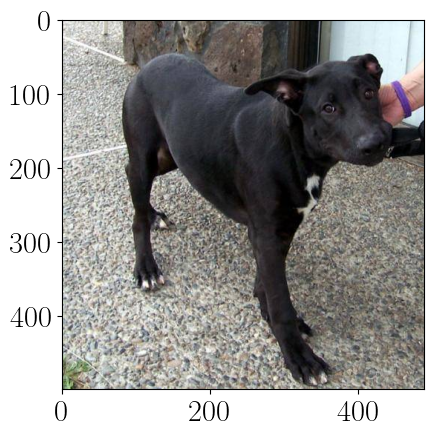

In [4]:
example_image = Image.open("example_images/dog_002.jpg").convert("RGB")

_ = plt.imshow(example_image)

In our paper, we mainly use the [MGIE](https://github.com/apple/ml-mgie) which is build on [InstructPix2Pix](https://www.timothybrooks.com/instruct-pix2pix).
To simplify the setup here, we provide an implementation of the pix2pix pipeline. However, any modern diffusion editing model, e.g., [FlowEdit](https://matankleiner.github.io/flowedit/), [Qwen-Image-Edit](https://huggingface.co/Qwen/Qwen-Image-Edit), [Ledits++](https://huggingface.co/spaces/leditsplusplus/project), or [FLUX.1-Kontext](https://huggingface.co/spaces/black-forest-labs/FLUX.1-Kontext-Dev), should work as well. 
Progress in diffusion editing simplifies the generation of interventional data!

In the future, we aim to include more models in our code base. If you want to contribute look into propgrad/pix2pix_interventions.py to see our general setup.

In [5]:
interventions = pix2pix_edit(
    img=example_image,
    instruction="Change the dog's fur color to white. Keep the background and other details the same.",
    cfg_txt=np.linspace(1.01, 15.0, 100, endpoint=True),
    SEED=1337,
    verbose=True
)

Loading pipeline components...: 100%|██████████| 6/6 [00:04<00:00,  1.27it/s]


Pix2Pix Instruction: Change the dog's fur color to white. Keep the background and other details the same.


100%|██████████| 100/100 [16:18<00:00,  9.79s/it]


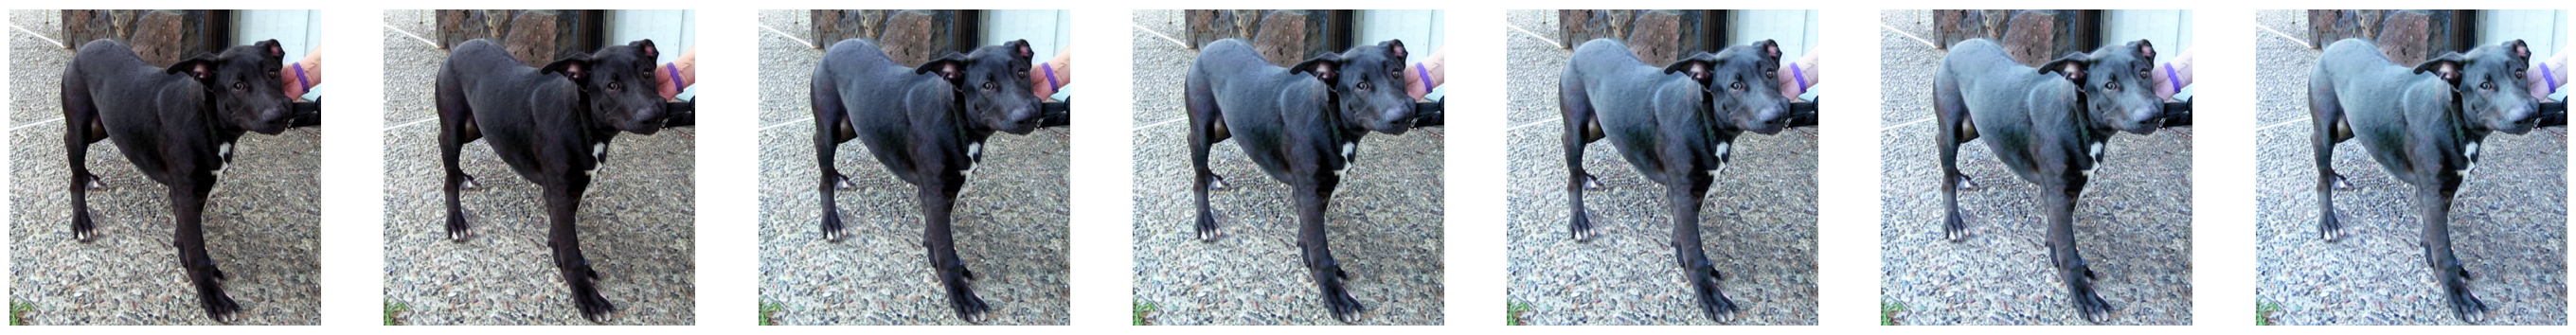

In [6]:
fig = subsample_plot(interventions, num=7)

figure = plt.figure(figsize=(4, 4))
camera = Camera(figure)
ax = figure.add_subplot(111)
ax.axis("off")
for img in interventions:
    ax.imshow(img)
    camera.snap()


animation = camera.animate(interval=100, repeat_delay=2000)

plt.close()
HTML(animation.to_html5_video())

## 3. Predict the Interventional Data and Study the Output Behavior

In [7]:
test_transform = transforms.Compose([
    # Resize the images to IMAGE_SIZE xIMAGE_SIZE
    transforms.Resize(size=(128, 128)),
    # Turn the image into a torch.Tensor
    # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
    transforms.ToTensor(),
    # normalize to [-1,1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


D = ImageList_DS([example_image] + interventions, test_transform)
loader = data.DataLoader(D, batch_size=10, shuffle=False)

logits_unb = perform_inference(M_unb, loader)
logits_dc = perform_inference(M_dc, loader)
logits_dd = perform_inference(M_dd, loader)

### Visualize the Shift in Behavior

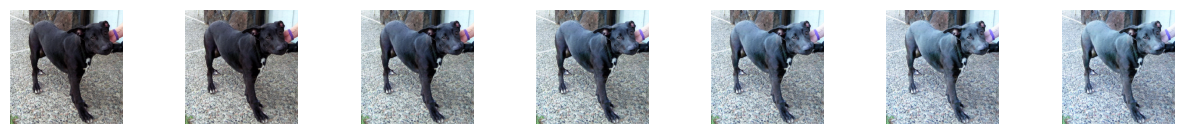

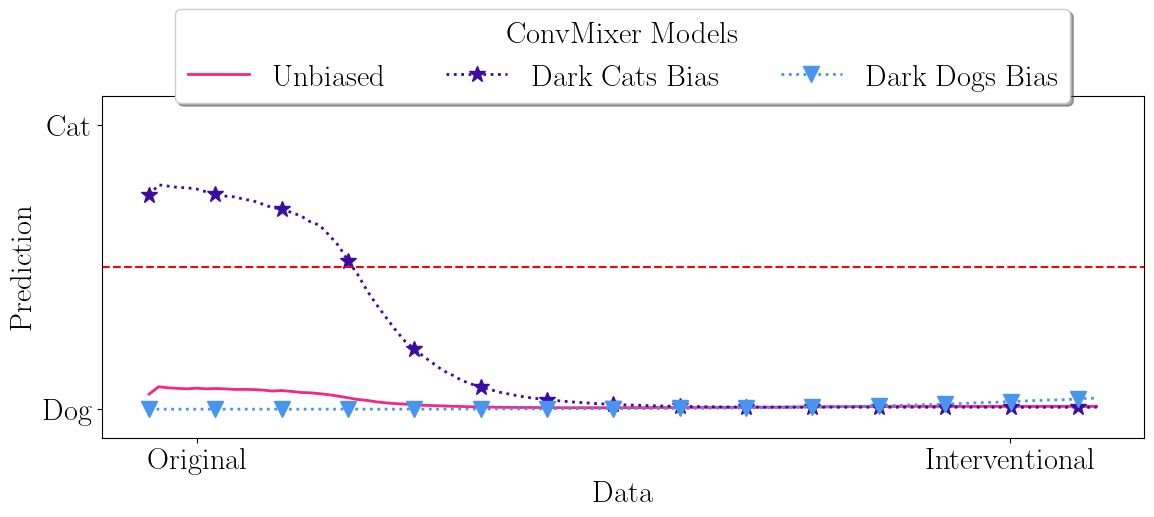

In [8]:
fig = subsample_plot(interventions, num=7, s=1.8)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)


# order should be cats, dogs
me = 7
lw = 2
ms = 12


c_unb = "#f72585" 
c_dcats = "#3a0ca3" 
c_ddogs = "#4895ef" 

num = len(D)
vals = np.arange(num)

ax.plot(vals, logits_unb[:,0], label="Unbiased", color=c_unb, linestyle="-", linewidth=lw, )
ax.plot(vals, logits_dc[:,0], label="Dark Cats Bias", color=c_dcats, linestyle=":", linewidth=lw, marker="*", markevery=me, markersize=ms)
ax.plot(vals, logits_dd[:,0], label="Dark Dogs Bias", color=c_ddogs, linestyle=":", linewidth=lw, marker="v", markevery=me, markersize=ms)
ax.axhline(0.5, color="r", linestyle="--")

ax.set_ylim((-0.1,1.1))

ax.set_xticks([num*0.05,num*0.9], ["Original", "Interventional"])
ax.set_yticks([0,1], ["Dog", "Cat"])


ax.set_ylabel("Prediction")
ax.set_xlabel("Data")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), title="ConvMixer Models",
          ncol=3, fancybox=True, shadow=True) 

fig.tight_layout()

In this case, we see that the model that is biased to predict cat for dark animals predicts cat in the beginning. In contrast, the other two models predict the correct class (dog). During the intervention, we lighten the fur color which leads to a flip in prediction for the dark cats biased model. The other models stay relatively consistent with their prediction for this local image.

## Next, let us measure the impact of our intervention:

In [10]:
z = Zollstock()

exp_prop_grad_unb, p_unb = z.shuffle_test(logits_unb[:,0])
exp_prop_grad_dc, p_dc = z.shuffle_test(logits_dc[:,0])
exp_prop_grad_dd, p_dd = z.shuffle_test(logits_dd[:,0])

table = pd.DataFrame({
    "Model": ["Unbiased", "Dark Cats Bias", "Dark Dogs Bias"],
    "Exp. Prop. Grad.": [exp_prop_grad_unb, exp_prop_grad_dc, exp_prop_grad_dd],
    "p-value": [p_unb, p_dc, p_dd],
    "Prediction Flips": [
        z.prediction_flips(logits_unb),
        z.prediction_flips(logits_dc),
        z.prediction_flips(logits_dd)
    ]
})

table

,Model,Exp. Prop. Grad.,p-value,Prediction Flips
0,Unbiased,0.001154,0.0,False
1,Dark Cats Bias,0.008243,0.0,True
2,Dark Dogs Bias,0.000384,0.0,False


In all cases, we observe significant shifts in behavior. Even the, in comparison, smaller changes for the unbiased model and the dark dogs biased model are significant according to our shuffle test. However, we observe the largest effect size for the dark cats biased model which is fits given that it is the only model that flips its prediction during the intervention.

Next, we can visualize the estimated null distribution and some shuffled variations for the unbiased model:

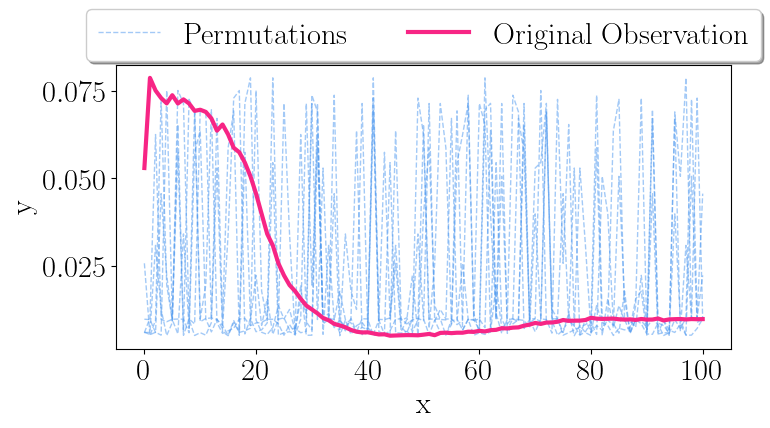

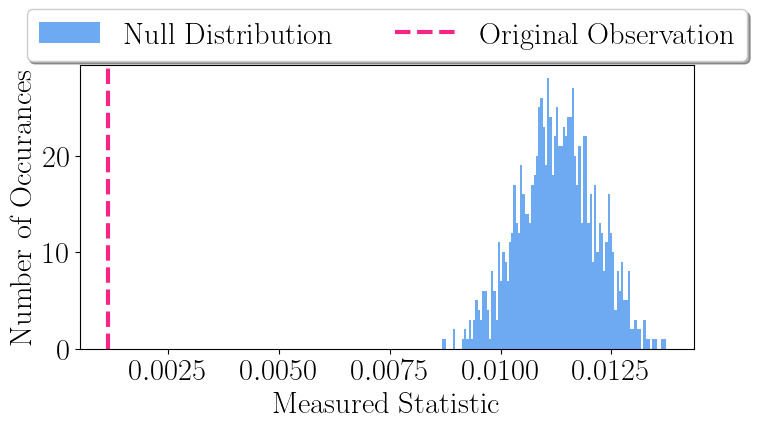

In [11]:
_ = z.shuffle_test(logits_unb[:,0], plot_null_dist=True, plot_shuffle=True)